In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from numpy.random import choice
from numpy.lib import pad
from math import sqrt, floor, ceil

### 1.1 Visualizing the data

In [2]:
def load_data(file):
    return loadmat(file)

In [3]:
data = load_data('./ex4data1.mat')
X = data['X']
y = np.array(list(map(lambda a: [0] if a[0] == 10 else a, data['y'])))

print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


In [4]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

def pad_with_ones(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 1
    vector[-pad_width[1]:] = 1
    return vector

def display_data(data):
    imgs = np.array([pad(data[i].reshape(20, 20).T, 1, pad_with_ones) for i in range(len(data))])
    
    m, height, width = imgs.shape
    n_row = floor(sqrt(m))
    n_col = ceil(m/n_row)
    
    imgs = unblockshaped(imgs, n_row*imgs.shape[1], n_col*imgs.shape[2])
    
    plt.gray()
    plt.imshow(imgs)

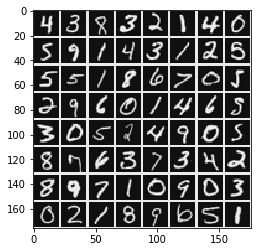

In [9]:
sample_data = X[choice(X.shape[0], 64, replace=False)]
# sample_data = X[0:64]
display_data(sample_data)

### 1.2 Model representation

In [10]:
weights = load_data('./ex4weights.mat')
theta_1 = weights['Theta1']
theta_2 = weights['Theta2']
print(theta_1.shape)
print(theta_2.shape)

(25, 401)
(10, 26)


### 1.3 Feedforward and cost function

In [11]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [ ]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    pass

In [22]:
def nn_cost_function_without_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    m = len(y)
    theta_1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size, input_layer_size+1)
    theta_2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape(num_labels, hidden_layer_size+1)
    
    theta_1_grad = np.zeros((theta_1.shape[0], theta_1.shape[1]))
    theta_2_grad = np.zeros((theta_2.shape[0], theta_2.shape[1]))

    z2 = np.c_[np.ones((X.shape[0],1)), X].dot(theta_1.T)
    a2 = sigmoid(z2)
    
    z3 = np.c_[np.ones((a2.shape[0],1)), a2].dot(theta_2.T)
    a3 = sigmoid(z3)
#     z2 = 
#     hx = sigmoid(theta.dot(X.T))
#     J = (-1/m)*(y.T.dot(np.log(hx)) + (1-y).T.dot(np.log(1-hx))) + (lamb/(2*m))*np.sum(np.power(theta[1:],2))
    
#     return J

In [23]:
nn_params = np.r_[theta_1.flatten(), theta_2.flatten()]
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lamb = 1

In [24]:
nn_cost_function_without_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)